In [2]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

from strawberryfields import ops

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [3]:
tf.set_random_seed(0)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3760036325194939765
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10943050548
locality {
  bus_id: 1
}
incarnation: 5561033067730252912
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


### Preparing dataset

We install a data from 

In [5]:
 def make_matrixes_4x4(x, axs_scale):  # TODO

        """
            идем матрицей 4х4 с шагом 1,
            тогда из мтарицы 8х8 получаем 5х5
        """
        output = []
        for i in range(0, axs_scale-3, 1):  # x
            for j in range(0, axs_scale-3, 1):  # y
                matrix = [x[i][j], x[i][j + 1], x[i][j + 2], x[i][j + 3],
                         x[i + 1][j], x[i + 1][j + 1], x[i + 1][j + 2], x[i + 1][j + 3],
                         x[i + 2][j], x[i + 2][j + 1], x[i + 2][j + 2], x[i + 2][j + 3],
                         x[i + 3][j], x[i + 3][j + 1], x[i + 3][j + 2], x[i + 3][j + 3]]
                
                output.append(matrix) 
        return output

**code to visualize samples from the dataset**

In [18]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1
        
    fig, axs = plt.subplots(nrows=rows, ncols=4)
    
    for i in range(samples_number):
        index = np.random.randint(len(samples))
        if samples_number > 4:
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]), cmap='gray')
        else:
            axs[i % 4].imshow(samples[index].reshape([8, 8]), cmap='gray')
            
    plt.show()

#     plt.savefig('Mnist/CNN/Digits.png')

In [14]:
def create_dataset(split=0.1):
    digits = load_digits()
    
    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)
    
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(x)*split)

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

In [15]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

## Quantum Neural Network Model

In [16]:
wires = 8
params_num = 48 + 30 + 34
kerr_value = np.pi


def myloss(circuit_output, targets):
    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


def outputs_to_predictions(outpt):
    return tf.round(outpt)

def circuit(X):

#     params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(20)]

    def shaper(x):
        """
        x - a single picture
        :param x: an array of pixels
        :return: shape and reshaped array of pixels
        """
        print(x)

        if x.shape[0] == 64:
            return 8, tf.reshape(x, [8, 8])
        elif x.shape[0] == 36:
            return 6, tf.reshape(x, [6, 6])
        elif x.shape[0] == 35:
            return 5, tf.reshape(x, [5, 5])
        elif x.shape[0] == 16:
            return 4, tf.reshape(x, [4, 4])
        elif x.shape[0] == 9:
            return 3, tf.reshape(x, [3, 3])
        elif x.shape[0] == 4:
            return 2, tf.reshape(x, [2, 2])

    def conv_4x4_layer(x, params, global_delta):
        """
        54 parameters
        :param x: input data with shape (4,)
        :param delta: parameters shift for the current layer
        :return: bosons amount in the 0's qumode.
        """
        
        eng, q = sf.Engine(4)
        
        quater_pi = tf.constant(np.pi / 4, dtype=tf.double)
        
        def layer(delta):
            ops.BSgate(quater_pi, 0.0) | (q[0], q[1])
            ops.BSgate(quater_pi, 0.0) | (q[2], q[3])
            ops.Rgate(params[0 + delta]) | q[0]
            ops.Rgate(params[1 + delta]) | q[1]
            ops.Rgate(params[2 + delta]) | q[2]
            ops.Rgate(params[3 + delta]) | q[3]
            ops.BSgate(quater_pi, 0.0) | (q[1], q[2])
            ops.BSgate(quater_pi, 0.0) | (q[0], q[3])
            ops.Rgate(params[4 + delta]) | q[0]
            ops.Rgate(params[5 + delta]) | q[1]
            ops.Rgate(params[6 + delta]) | q[2]
            ops.Rgate(params[7 + delta]) | q[3]
            ops.Dgate(params[8 + delta]) | q[0]
            ops.Dgate(params[9 + delta]) | q[1]
            ops.Pgate(params[10 + delta]) | q[2]
            ops.Pgate(params[11 + delta]) | q[3]

        with eng:
            for d in range(4):
                for j in range(4):
                    ops.Sgate(1.5, x[:, j + 4 * d]) | q[j]
                
                layer(global_delta + d * 12)
                
            ops.Kgate(tf.constant(kerr_value, dtype=tf.double)) | q[0]
            ops.Kgate(tf.constant(kerr_value, dtype=tf.double)) | q[1]
            

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=5, eval=False, batch_size=num_inputs)
        
        modes = 4*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization
        return tf.cast(output, dtype=tf.float64)
    
    def conv_3x3_layer(x, params, global_delta):
        """
        54 parameters
        :param x: input data with shape (4,)
        :param delta: parameters shift for the current layer
        :return: bosons amount in the 0's qumode.
        """
        
        eng, q = sf.Engine(3)
        
        quater_pi = tf.constant(np.pi / 4, dtype=tf.double)
        
        def layer(delta):
            ops.BSgate(quater_pi, 0.0) | (q[0], q[1])
#             ops.BSgate(quater_pi, 0.0) | (q[2], q[1])
            ops.Rgate(params[0 + delta]) | q[0]
            ops.Rgate(params[1 + delta]) | q[1]
            ops.Rgate(params[2 + delta]) | q[2]
            ops.BSgate(quater_pi, 0.0) | (q[1], q[2])
#             ops.BSgate(quater_pi, 0.0) | (q[0], q[2])
            ops.Rgate(params[3 + delta]) | q[0]
            ops.Rgate(params[4 + delta]) | q[1]
            ops.Rgate(params[5 + delta]) | q[2]
            ops.Dgate(params[6 + delta]) | q[0]
            ops.Dgate(params[7 + delta]) | q[1]
            ops.Pgate(params[8 + delta]) | q[0]
            ops.Pgate(params[9 + delta]) | q[1]

        with eng:
            for d in range(3):
                for j in range(3):
                    ops.Sgate(1.5, x[:, j + 3 * d]) | q[j]
                
                layer(global_delta + d * 10)
                
            ops.Kgate(tf.constant(kerr_value, dtype=tf.double)) | q[0]
            ops.Kgate(tf.constant(kerr_value, dtype=tf.double)) | q[1]

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=5, eval=False, batch_size=num_inputs)
        
        modes = 3*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization
        return tf.cast(output, dtype=tf.float64)


    def full_con_layer(x, delta, params):

        eng, q = sf.Engine(3)
        
        quater_pi = tf.constant(np.pi / 4)            

        with eng:
            for k in range(3):
                for j in range(3):
                    ops.Sgate(1.5, x[:, j+3*k]) | q[j]
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[1])
                ops.BSgate(quater_pi, 0) | (q[2], q[1])
                
                for j in range(3):
                    ops.Rgate(params[j + 6 * k + delta])
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[2])
                ops.BSgate(quater_pi, 0) | (q[1], q[0])
                    
                for j in range(3):
                    ops.Rgate(params[j + 3 * (2 * k + 1)  + delta])
            
            ops.Dgate(params[18 + delta]) | q[0]
            ops.Dgate(params[19 + delta]) | q[1]
            ops.Dgate(params[20 + delta]) | q[2]
            ops.Pgate(params[21 + delta]) | q[0]
            ops.Pgate(params[22 + delta]) | q[1]
            ops.Pgate(params[23 + delta]) | q[2]

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=5, eval=False, batch_size=num_inputs)


        modes = 3*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]

        return output
    
    def make_matrixes_3x3(x, axs_scale):  # TODO

        """
            идем матрицей 3х3 с шагом 1,
            тогда из мтарицы 5х5 получаем 3х3
        """
        output = []
        for i in range(0, axs_scale-2, 1):  # x
            for j in range(0, axs_scale-2, 1):  # y
                matrix = [x[i][j], x[i][j + 1], x[i][j + 2],
                         x[i + 1][j], x[i + 1][j + 1], x[i + 1][j + 2],
                         x[i + 2][j], x[i + 2][j + 1], x[i + 2][j + 2]]
                
                output.append(matrix) 
        return tf.cast(output, dtype=tf.float64)

    def single_circuit(input_x):  
        
        params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(params_num)]
        
        _x = tf.map_fn(lambda x: conv_4x4_layer(x, params, 0), input_x)  # нужно сделать так, чтобы передавать кол-во сверток
        _x = tf.reshape(_x, [_x.shape[0], 5, 5])
        _x = tf.map_fn(lambda x: make_matrixes_3x3(x, 5), input_x)
#         print(_x.shape)
        _x = tf.map_fn(lambda x: conv_3x3_layer(x, params, 48), _x)
        output = full_con_layer(_x, 78, params)
        return output

    return single_circuit(X)

## Start of the learning

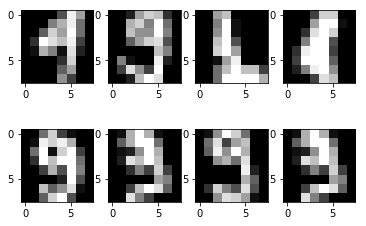

In [19]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

In [15]:
# reshape input as image
train_x = np.reshape(train_x, [len(train_y), 8, 8])
print('train_x shape', train_x.shape)
test_x = np.reshape(test_x, [len(test_y), 8, 8])
print('test_x shape', test_x.shape)

train_x shape (326, 8, 8)
test_x shape (36, 8, 8)


In [16]:
# we will make matrixes now and feed them into QCNN
train_x = np.array([make_matrixes_4x4(x, 8) for x in train_x])
print(train_x.shape)
test_x = np.array([make_matrixes_4x4(x, 8) for x in test_x])
print(test_x.shape)

(326, 25, 16)
(36, 25, 16)


In [17]:
lr = 0.0025
# steps = [10, 30, 50, 70, 100, 200, 300] #, 500, 700, 1000]
# steps = [10, 20, 30, 40, 50, 60, 70, 80, 90]
steps = [i for i in range(10, 810, 50)]
# steps = np.arange(500, 501, 10)
print(steps)
batch_size = 2

test_acc, test_loss = [], []
train_acc, train_loss = [], []

hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'Adam',
               'init_learning_rate': lr,
               'log_every': 1,
               'warm_start': False}

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)

    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)

    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'])

    train_score = learner.score_circuit(X=train_x, Y=train_y,
                                       outputs_to_predictions=outputs_to_predictions)

    train_acc.append(train_score['accuracy'])
    train_loss.append(train_score['loss'])

[10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760]

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.0025
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - Adam
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52482ef5c0>, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_session_config': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_save_che

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].plot(steps, test_acc, label = 'val')
ax[0].plot(steps, train_acc, label = 'train')
ax[0].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')


ax[1].plot(steps, test_loss, label = 'val')
ax[1].plot(steps, train_loss, label = 'train')
ax[1].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

plt.show()

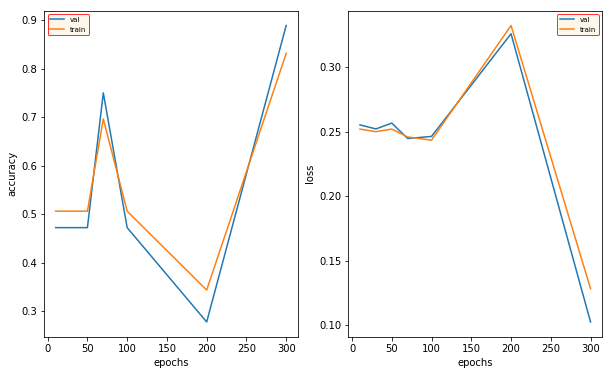

In [ ]:
print(steps)
print(test_acc)
print(test_loss)
print(train_acc)
print(train_loss)

In [ ]:
steps = [10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610, 660, 710, 760]
test_acc = [0.4722222, 0.4722222, 0.4722222, 0.5277778, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss = [0.26539844, 0.25247163, 0.24599239, 0.23269568, 0.07240413, 0.04695781, 0.048534386, 0.049218088, 0.049329577, 0.047678272, 0.049382284, 0.045902412, 0.028912187, 0.02784758, 0.027621536, 0.0273067516]
train_acc = [0.506135, 0.506135, 0.506135, 0.4969325, 0.8773006, 0.892638, 0.898773, 0.81595093, 0.83435583, 0.82515335, 0.9018405, 0.9018405, 0.892638, 0.904908, 0.90809814, 0.90619632]
train_loss = [0.258721, 0.24978155, 0.24509045, 0.23704013, 0.11165709, 0.092643574, 0.094103746, 0.093480674, 0.09541248, 0.091836018, 0.09012714, 0.08897385, 0.08528338, 0.08988538, 0.08804665, 0.08357855]

In [ ]:
steps_10 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
test_acc_10 = [0.4722222, 0.5277778, 0.4722222, 0.4722222, 0.4722222, 0.4722222, 0.75, 0.8333333, 0.4722222]
test_loss_10 = [0.25533408, 0.2492058, 0.2521781, 0.2559515, 0.25670254, 0.25078335, 0.24477178, 0.24312772, 0.24825239]
train_acc_10 = [0.506135, 0.49386504, 0.506135, 0.506135, 0.506135, 0.506135, 0.69631904, 0.76993865, 0.506135]
train_loss_10 = [0.25205815, 0.25026393, 0.25004363, 0.25184968, 0.25208154, 0.24835382, 0.24597192, 0.243427, 0.2444048]


In [ ]:
steps_100 = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
test_acc_100 = [0.4722222, 0.4722222, 0.9166667, 0.6944444, 0.8055556, 0.6388889, 0.9444444, 0.7777778, 0.8888889, 0.9722222]
test_loss_100 = [0.24637508, 0.24238229, 0.23169719, 0.22310609, 0.20621975, 0.2101154, 0.10823513, 0.18330397, 0.12060894, 0.05738535]
train_acc_100 = [0.506135, 0.506135, 0.8619632, 0.76380366, 0.7791411, 0.64723927, 0.8803681, 0.76687115, 0.8404908, 0.87116563]
train_loss_100 = [0.2434739, 0.2421395, 0.23379704, 0.22443657, 0.20956668, 0.24010608, 0.14303848, 0.18759845, 0.1575147, 0.10885152]

In [ ]:
steps_200 = [200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
test_acc_200 = [0.2777778, 0.4722222, 0.2777778, 0.4722222, 0.4722222, 0.4722222, 0.4722222, 0.9166667, 0.8611111, 0.8333333]
test_loss_200 = [0.3260248, 0.33777714, 0.27288556, 0.24445115, 0.2407014, 0.24346107, 0.24354379, 0.21108432, 0.18300204, 0.14797962]
train_acc_200 = [0.3260248, 0.33777714, 0.27288556, 0.24445115, 0.2407014, 0.24346107, 0.24354379, 0.21108432, 0.18300204, 0.14797962]
train_loss_200 = [0.33245465, 0.31910473, 0.2680802, 0.24313298, 0.23924297, 0.24053577, 0.24027388, 0.2169742, 0.19922441, 0.16656084]

In [ ]:
steps_300 = [300, 310, 320, 330, 340, 350, 360, 370, 380, 390]
test_acc_300 = [0.8888889, 0.9722222, 0.9166667, 0.8611111, 0.9722222, 0.8611111, 0.8055556, 0.9722222, 0.9722222, 0.8888889]
test_loss_300 = [0.102434084, 0.07757228, 0.1054329, 0.10779135, 0.084479965, 0.104366094, 0.14693841, 0.0690015, 0.061726145, 0.07812963]
train_acc_300 = [0.83128834, 0.87116563, 0.82515335, 0.83435583, 0.8834356, 0.81288344, 0.78220856, 0.86503065, 0.86809814, 0.85276073]
train_loss_300 = [0.12828718, 0.118024744, 0.15573135, 0.13010903, 0.12431317, 0.13252366, 0.15944484, 0.1145529, 0.10716744, 0.11921794]

In [ ]:
steps_400 = [400, 410, 420, 430, 440, 450, 460, 470, 480, 490]
test_acc_400 = [0.9166667, 0.9444444, 0.9444444, 0.8888889, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss_400 = [0.08832291, 0.066938385, 0.055378105, 0.08896741, 0.044023342, 0.051176783, 0.042010423, 0.03925246, 0.046074834, 0.038479067]
train_acc_400 = [0.8742331, 0.86809814, 0.87116563, 0.84969324, 0.88650304, 0.8834356, 0.86503065, 0.8803681, 0.88650304, 0.892638]
train_loss_400 = [0.11873258, 0.100314334, 0.10142938, 0.13609096, 0.08990029, 0.09769938, 0.10213115, 0.0937205, 0.096464336, 0.0900929]

In [ ]:
steps_500 = [500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]
test_acc_500 = [0.8611111,1.0, 0.9722222, 0.9722222, 0.8333333, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9444444, 0.9444444]
test_loss_500 = [0.11058644, 0.04555819, 0.03817101, 0.044280767, 0.11721501, 0.075931035, 0.07367016, 0.051957928, 0.05477415, 0.057516534, 0.06252424]
train_acc_500 = [0.79447854, 0.8558282, 0.8619632, 0.8773006, 0.78527606, 0.87116563, 0.8435583, 0.86503065, 0.8558282, 0.87116563, 0.84969324]
train_loss_500 = [0.15625618, 0.10867112, 0.10148184, 0.09246552, 0.14598271, 0.12232937, 0.12490412, 0.099485986, 0.10899202, 0.10792504, 0.11183892]

In [ ]:
steps_600 = [600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]
test_acc_600 = [0.9444444, 0.9444444, 0.9444444, 0.8333333, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 0.9722222, 1.0]
test_loss_600 = [0.06252424, 0.07449654, 0.060363855, 0.19219933, 0.06514981, 0.07018269, 0.07053578, 0.0666634, 0.04971951, 0.03820865, 0.037974548]
train_acc_600 = [0.84969324, 0.82515335, 0.86809814, 0.6779141, 0.8803681, 0.8773006, 0.8834356, 0.8834356, 0.8834356, 0.8803681, 0.8619632]
train_loss_600 = [0.11183892, 0.122868195, 0.10332003, 0.22127774, 0.1102514, 0.11547903, 0.114190795, 0.11246704, 0.10300433, 0.0974206, 0.10212395]

In [ ]:
steps_700 = [700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800]
test_acc_700 = [1.0, 0.9166667, 0.9722222, 0.75, 0.9444444, 0.9722222, 0.9444444, 0.9722222, 0.9722222, 0.9722222, 0.9722222]
test_loss_700 = [0.037974548, 0.06337907, 0.052290127, 0.14419624, 0.06728235, 0.050431084, 0.05878124, 0.046777025, 0.031735107, 0.027525093, 0.034861945]
train_acc_700 = [0.8619632, 0.8834356, 0.88957053, 0.74846625, 0.86809814, 0.8803681, 0.8834356, 0.8773006, 0.88650304, 0.8803681, 0.9018405]
train_loss_700 = [0.10212395, 0.10790726, 0.09075809, 0.16427828, 0.10321006, 0.09178666, 0.099935405, 0.09095793, 0.08764078, 0.09097304, 0.0880628]

# 1 vs 7

In [ ]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=7)

In [ ]:
# reshape input as image
train_x = np.reshape(train_x, [len(train_y), 8, 8])
print('train_x shape', train_x.shape)
test_x = np.reshape(test_x, [len(test_y), 8, 8])
print('test_x shape', test_x.shape)

In [ ]:
# we will make matrixes now and feed them into QCNN
train_x = np.array([make_matrixes_4x4(x, 8) for x in train_x])
print(train_x.shape)
test_x = np.array([make_matrixes_4x4(x, 8) for x in test_x])
print(test_x.shape)

In [ ]:
lr = 0.0015
# steps = [10, 30, 50, 70, 100, 200, 300] #, 500, 700, 1000]
steps = [i for i in range(10, 811, 50)]
# steps = np.arange(500, 501, 10)
print(steps)
batch_size = 2

test_acc, test_loss = [], []
train_acc, train_loss = [], []

hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'Adam',
               'init_learning_rate': lr,
               'log_every': 1,
               'warm_start': False}

for step in steps:

    learner = CircuitLearner(hyperparams=hyperparams)

    learner.train_circuit(X=train_x, Y=train_y, steps=step, batch_size=batch_size)

    test_score = learner.score_circuit(X=test_x, Y=test_y,
                                       outputs_to_predictions=outputs_to_predictions)

    test_acc.append(test_score['accuracy'])
    test_loss.append(test_score['loss'])

    train_score = learner.score_circuit(X=train_x, Y=train_y,
                                       outputs_to_predictions=outputs_to_predictions)

    train_acc.append(train_score['accuracy'])
    train_loss.append(train_score['loss'])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].plot(steps, test_acc, label = 'val')
ax[0].plot(steps, train_acc, label = 'train')
ax[0].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')


ax[1].plot(steps, test_loss, label = 'val')
ax[1].plot(steps, train_loss, label = 'train')
ax[1].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

plt.show()